 # <center> Lecture 3: The Beta-Binomial Bayesian Model </center>  
 
 ## <center> Instructor: Dr. Hu Chuan-Peng </center>  


 ## <center> Part 1: Beta 先验 </center>

上节课的内容主要是关注了贝叶斯的思路：即我们如何根据信息更新自己对某个事件/变量的信念，并顺便比较了一下贝叶斯和频率学派对于同一事件的不同解读视角。  

🎯接下来，我们将贝叶斯理念融入心理学研究中，探索其如何优化我们对认知过程的推理过程。

### 以随机点运动任务（Random motion dot task）为例  

- 随机点运动任务是一个经典的认知任务，是研究感知决策(perceptual decision making)的标准范式。  
- 被试任务：  
   - 被试观察屏幕上的点，这些点以不同的一致性水平随机移动。  
   - 任务是判断这些点的主要移动方向（例如，向左还是向右）。  
- 实验可以在人类和动物（如老鼠）上进行，以探索人类和动物的大脑如何完成这一过程。  

<center>  
    <table>  
            <tr>  
                <td><img src="https://cdn.kesci.com/upload/sjwnyi477j.gif?imageView2/0/w/400/h/400" alt=""></td>  
                <td><img src="https://cdn.kesci.com/upload/sjwnyt1yq4.gif?imageView2/0/w/400/h/400" alt=""></td>  
            </tr>  
            <tr>  
                <td>一致性10%</td>  
                <td>一致性60%</td>  
            </tr>  
    </table>  
</center>  

-----------  
-----------

正确率与任务难度：  
   - 任务的难度由点的运动一致性决定。一致性低，点的主要方向不明显，任务难度大；一致性高，点的主要方向明显，任务难度小。  
   - 正确率随一致性的增加而提高，通常在心理物理曲线中展示。  

根据正确率的数据，我们可以使用心理物理曲线描述运动强度（点的一致性百分比）与决策正确率之间的关系。  

![image](https://cdn.kesci.com/upload/sjzjcgwjrm.png?imageView2/0/w/640/h/640)  

> Shooshtari, S. V., Sadrabadi, J. E., Azizi, Z., & Ebrahimpour, R. (2019). Confidence representation of perceptual decision by EEG and eye data in a random dot motion task. Neuroscience, 406, 510–527. https://doi.org/10.1016/j.neuroscience.2019.03.031  

------  

------


正确率这个指标与被试在每个试次上的关系是什么？回想一下刚刚讲到的频率主义与贝叶斯主义的区别。  

正确率给出一个单一的指标，而不是对无法观察的“被试做正确的能力”进行估计，也没有纳入估计的不确定性。  

假如从贝叶斯的角度出发，我们根据被试在某种条件下的表现来估计其做正确的能力？  

我们以Evans et al.（2020, Exp. 1） 的数据为例进行探索。  

> Evans, N. J., Hawkins, G. E., & Brown, S. D. (2020). The role of passing time in decision-making. Journal of Experimental Psychology: Learning, Memory, and Cognition, 46(2), 316–326. https://doi.org/10.1037/xlm0000725  


In [1]:
# 导入必要的库
import scipy.stats as st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import preliz as pz

from scipy.stats import binom

# 为 preliz 绘图设置图形样式
pz.style.library["preliz-doc"]["figure.dpi"] = 100
pz.style.library["preliz-doc"]["figure.figsize"] = (10, 4)
pz.style.use("preliz-doc")

# 使用 pandas 导入示例数据
try:
  data = pd.read_csv("/home/mw/input/bayes3797/evans2020JExpPsycholLearn_exp1_clean_data.csv") 
except:
  data = pd.read_csv('data/evans2020JExpPsycholLearn_exp1_clean_data.csv')

# 选择特定模式的数据进行演示：
# 筛选 correct 为 1 的数据，并随机选取30个
data_correct_1 = data[data['correct'] == 1].sample(n=30, random_state=42)

# 筛选 correct 为 0 的数据，并随机选取20个
data_correct_0 = data[data['correct'] == 0].sample(n=20, random_state=42)

# 合并两部分数据，形成新的数据集
df = pd.concat([data_correct_1, data_correct_0], ignore_index=True)

In [2]:
# 只显示特定列
df[['subject', 'numberofDots', 'percentCoherence', 'correct', 'RT']].head()

,subject,numberofDots,percentCoherence,correct,RT
0,82111,40,5,1,1173
1,82111,40,5,1,1820
2,82111,40,5,1,694
3,82111,40,5,1,1355
4,82111,40,5,1,1480


In [3]:
# 非选课的同学，可以使用和鲸社区的“2024社区镜像”，运行以下的代码安装必要的模块，需要3-5分钟的时间完成加载
# 后续会有专门的社区公开镜像，给大家提前配置好运行环境
# 将下列代码行解除注释，删除“#”，运行即可：
# !conda install -y graphviz bambi=0.13.0 pymc=5.16.2 PreliZ=0.9.0 ipympl=0.9.4 pingouin=0.5.4

# docker部署和使用教程链接：https://zhuanlan.zhihu.com/p/719739087
# docker pull hcp4715/pybaysian:latest
# docker run -it --rm -p 8888:8888 hcp4715/pybaysian:latest

##### 接下来，我们将通过该数据学习以下知识点：  

1. 如何为结果为“正确与否”的数据建立概率模型  
2. 如何为该类数据设置一个先验模型  
3. 如何通过数据来更新先验模型

### 连续变量的先验模型

#### "正确与否(0/1)数据"的处理  

在随机点运动任务中，被试正确探测出点的运动方向的取值范围在0-1之间，不同被试、不同条件下的真实的能力不同（与上节课的“重复成功率”类似）。  

假如我们对人们在5%一致条件下进行正确判断的能力感兴趣。  

- 如果我们还没有招募被试进行实验，则只能对被试在不同条件下的表现进行推断。根据先前的文献(Vafaei Shooshtari et al., 2019)，当随机点的一致性为5%时，个体的正确率约为70%  

  > Shooshtari, S. V., Sadrabadi, J. E., Azizi, Z., & Ebrahimpour, R. (2019). Confidence representation of perceptual decision by EEG and eye data in a random dot motion task. Neuroscience, 406, 510–527. https://doi.org/10.1016/j.neuroscience.2019.03.031  

- 根据文献的信息，我们可以建立一个关于正确判断能力的先验分布：例如，个体正确率为70%的概率为0.8，而个体正确率为60%或80%的概率为0.1 (这是我们上节课学习的内容🤓)。  

但考虑到正确率为0-1之间的任意值，我们只采用0.6、0.7和0.8三个值，似乎有点武断。可能连续概率模型(continuous prior probability)更合适?  

🤔如何建立连续变量的先验概率模型？  

In [4]:
# 创建离散先验分布数据
prior_disc = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]         # 离散先验分布的取值
prior_dis_prob = [0, 0, 0, 0, 0, 0.10, 0.80, 0.10, 0, 0]  # 对应的概率
prior_disc_data = pd.DataFrame({'ACC': prior_disc, 'f(ACC)': prior_dis_prob})

# 将'ACC'列的数据类型转换为字符串，以便在图表中正确显示
prior_disc_data['ACC'] = prior_disc_data['ACC'].astype('str')

# 创建一个单独的图表
plt.figure(figsize=(8, 5))

# 绘制离散先验分布的条形图
sns.barplot(data=prior_disc_data, x='ACC', y='f(ACC)', palette="deep")

# 设置图表的标题
plt.title("Discrete Prior")

# 移除图的上边框和右边框
sns.despine()

# 显示图表
plt.show()

<Figure size 800x500 with 1 Axes>

### Beta 先验模型

⏰回顾一下离散型随机变量及其**概率质量函数(probability mass function, pmf)**  

> 在随机点运动任务的例子中，假如正确率(ACC)只有几个可能的取值，则其是离散型随机变量$Y$，可以通过概率质量函数来描述离散型随机变量在各特定取值上的概率，对所有正确率的取值来说，$0\leq ACC \leq 1$， 并且 $\sum_{all\,\pmb{y}}f(ACC) = 1$，ACC取值的所有概率之和为1。

**Continuous probability models**  

当正确率是一个连续的随机变量时，它服从于一个分布$f(ACC)$, 又被称概率密度函数(probability density function, pdf)  

pdf 与 pmf 有类似的性质：  

- $f(ACC) \ge 0$  
- $\int_{\text{ACC}} f(\text{ACC}) \, d\text{ACC} = 1$，即 $f(\text{ACC})$ 曲线下的面积之和为 1  
- 当$a \le b$时，$P(a < ACC < b) = \int_a^b f(ACC) dACC$  

![Image Name](https://cdn.kesci.com/upload/s0ywgsar31.jpg?imageView2/0/w/500/h/500)  
> source:https://www.zhihu.com/question/263467674/answer/1117758894  

--------------  
--------------

**为正确率（ACC）选择一个合适的分布 -- Beta分布**  

虽然我们潜意识里可能认为正确率服从正态分布，但是，在统计世界中存在着许多分布。  

在这里，我们假设随机点运动任务中的正确率服从Beta分布。  

- 选择 Beta 分布的关键在于，其取值范围满足[0,1]，  
- 此外，Beta分布通过两个超参数(hyperparameters)，$\alpha \; (\alpha>0)\;和 \beta\;(\beta>0)$ 调节分布的形态。  

$$  
\text{ACC} \sim \text{Beta}(\alpha, \beta)  
$$  


**Beta分布的参数：控制分布形状—— $\alpha$和$\beta$**  

调整$\alpha$和$\beta$的大小，观察分布形状的变化  

下图展示了不同$\alpha$和$\beta$下pdf形态的变化：  


In [5]:
# 创建一个3x3的网格子图，每个子图的尺寸为10x10
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# 绘制 Beta(1, 5) 分布的PDF，并显示置信区间
pz.Beta(1, 5).plot_pdf(pointinterval=True,ax=axs[0, 0], legend="title")
pz.Beta(1, 2).plot_pdf(pointinterval=True,ax=axs[0, 1], legend="title")
pz.Beta(3, 7).plot_pdf(pointinterval=True,ax=axs[0, 2], legend="title")
pz.Beta(1, 1).plot_pdf(pointinterval=True,ax=axs[1, 0], legend="title")
pz.Beta(5, 5).plot_pdf(pointinterval=True,ax=axs[1, 1], legend="title")
pz.Beta(20, 20).plot_pdf(pointinterval=True,ax=axs[1, 2], legend="title")
pz.Beta(7, 3).plot_pdf(pointinterval=True,ax=axs[2, 0], legend="title")
pz.Beta(2, 1).plot_pdf(pointinterval=True,ax=axs[2, 1], legend="title")
pz.Beta(5, 1).plot_pdf(pointinterval=True,ax=axs[2, 2], legend="title")

# 自动调整子图之间的间距，以防止标签重叠
plt.tight_layout()

# 显示绘制的图形
plt.show()

<Figure size 1000x1000 with 9 Axes>

**Beta分布的概率密度函数pdf**  

$$  
f(\text{ACC}) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \text{ACC}^{\alpha-1} (1-\text{ACC})^{\beta-1} \;\;  \text{for} \; \text{ACC} \in [0,1]  
$$  

*简单了解：*  

* *$\Gamma$与阶乘有关*  

* *$\Gamma(z) = \int_0^\infty x^{z-1}e^{-y}dx$ 且 $\Gamma(z + 1) = z \Gamma(z)$*  

* *当z是正整数的时候，$\Gamma(z)$ 可以被简化为$\Gamma(z) = (z-1)!$*

**调整Beta先验**  

在这里我们选择$\text{ACC} \sim \text{Beta}(70, 30)$作为合理的先验模型  

* *关于为何$\alpha=70, \beta=30$，感兴趣的同学可自行查看课后bonus💐*  

带入公式，可以计算出先验$f(ACC)$的pdf：  

- pdf:  
$$  
f(ACC) = \frac{\Gamma(100)}{\Gamma(70)\Gamma(30)} ACC^{69}(1-ACC)^{29} \;\; \text{ for } \; ACC \in [0,1] .  
$$  


以下就是我们这个先验似然的可视化： 

In [6]:
# 创建离散先验分布数据
prior_disc = [0.1, 0.2, 0.3,0.4,0.5,0.6, 0.7, 0.8,0.9, 1.0]         # 离散先验分布的取值
prior_dis_prob = [0, 0, 0, 0, 0, 0.10, 0.80, 0.10, 0, 0]  # 对应的概率
prior_disc_data = pd.DataFrame({'ACC': prior_disc, 'f(ACC)': prior_dis_prob}) 
# 将'ACC'列的数据类型转换为字符串，以便在图表中正确显示
prior_disc_data['ACC'] = prior_disc_data['ACC'].astype('str')

# 创建一个包含两个子图的图表
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# 在第一个子图中绘制离散先验分布的条形图
sns.barplot(data=prior_disc_data, x='ACC', y='f(ACC)', palette="deep", ax=ax1)
# 设置第一个子图的标题
ax1.set_title("discrete prior")

# 在第二个子图中绘制连续先验分布的线图
pz.Beta(70, 30).plot_pdf(pointinterval=True,ax=ax2, legend="title") # 在这里示范了一个 Beta 分布的参数，你可以根据需要修改这些参数
# # 设置第二个子图的标题
ax2.set_title("continuous prior\n(Beta(alpha=70,beta=30))")

# 设置第二个子图的 x 轴范围为 0 到 1
ax2.set_xlim(0, 1)

# # # 移除图的上边框和右边框
sns.despine()

<Figure size 1500x400 with 2 Axes>

## <center>Part 2 Binomial 与似然 </center>

### 二项数据模型&似然函数


确定先验之后，第二步，我们需要根据收集的数据构建似然函数  
- 我们选取了 Evans 等(2020)的研究数据作为我们的案例展示，为计算方便，我们仅选取一名被试的数据，并对该被试数据进行选择以方便展示。  
- 假设该被试的数据包含 50 次试验的随机点运动任务，我们希望通过 50 次的实验来估计被试在5%一致性条件下的判断正确的能力  
  - 我们假设参与者的每一次判断是否正确是相互独立的。  
- 假设参与者的正确判断次数为 Y，我们可以做出以下假设：  
	1. 每次试验的正确与否是相互独立的（试验A的结果不会影响试验B）。  
	2. 每次试验参与者正确判断的概率为ACC。

在这两个假设下，正确判断次数 Y 和正确率ACC之间的关系符合二项分布：  
$$  
Y | \text{ACC} \sim \text{Bin}(50, \text{ACC})  
$$  

在不同的正确率下，出现特定正确判断次数Y的概率$f(y|\text{ACC}) \quad y \in \{0,1,2,…,50\}$ 可以表示为：  

$$  
f(y|\text{ACC}) = P(Y=y | \text{ACC}) = \binom{50}{y} \text{ACC}^y (1-\text{ACC})^{50-y}  
$$

我们来进行一些具体的计算  
- 假设ACC = 0.1，那么在50 次试验中，每个可能的正确判断次数$Y \in ({1,2...50})$，而出现特定结果的概率可以表示为：  
$$  
f(Y=1|\pi=0.1) = \binom{50}{1} 0.1^1 (1-0.1)^{49}  
$$  
$$  
f(Y=2|\pi=0.1) = \binom{50}{2} 0.1^2 (1-0.1)^{48}  
$$  
$$  
...  
$$  
$$  
f(Y=49|\pi=0.1) = \binom{50}{49} 0.1^{49} (1-0.1)^{1}  
$$  
$$  
f(Y=50|\pi=0.1) = \binom{50}{50} 0.1^{50} (1-0.1)^{0}  
$$  

我们可以把这50个概率值画出来。

In [7]:
# 创建一个 Binomial 分布，参数为 n=50（试验次数），p=0.1（正确率概率）
binom = pz.Binomial(n=50, p=0.1)

# 绘制该分布的概率密度函数 (PDF)
binom.plot_pdf()

# 移除图的上边框和右边框
sns.despine()

# 显示图表
plt.show()

<Figure size 1000x400 with 1 Axes>

**随机点运动任务中的正确率分布**  

在随机点运动任务中，正确率描述了参与者正确判断点运动方向的概率。在不同的正确率下，参与者在50次实验中正确判断的次数Y会有不同的分布情况。  

我们可以模拟不同的ACC，并展示每个ACC下，正确判断次数Y的分布图。  

（注：这里只展示了当正确率 =0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 九种情况下的分布图，但是记住ACC的取值其实是[0,1]之间的任意数，有无穷多个的）

In [8]:
# 导入必要的库
import numpy as np
import pandas as pd
from scipy.stats import binom
import seaborn as sns
import matplotlib.pyplot as plt

# 设置二项分布的参数
n = 50  # 总试验次数
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # 不同的 p 值列表
k = np.arange(0, 51)                                      # 创建一个包含从0到50的整数的数组

# 创建一个包含 'Y' 列的 DataFrame
dist_all_pi = pd.DataFrame({'Y': k})

# 计算每个 'Y' 对应的概率，并将结果存储在相应列中
for p in p_values:
    column_name = f'{p}'
    dist_all_pi[column_name] = dist_all_pi['Y'].apply(lambda x: binom.pmf(x, n, p))

# 使用 stack() 和 reset_index() 转换数据为长格式
melted_data = dist_all_pi.set_index('Y').stack().reset_index()
melted_data.columns = ['Y', 'p', 'prob']

# 创建一个 FacetGrid 对象，用于绘制子图
plot_all_pi = sns.FacetGrid(melted_data, col='p', col_wrap=3)

# 使用柱状图绘制概率分布
plot_all_pi.map(sns.barplot, 'Y', 'prob', color="grey", order=None)

# 设置 x 和 y 轴的刻度和范围
plot_all_pi.set(xticks=[0, 10, 20, 30, 40, 50],
                yticks=[0.00, 0.05, 0.10, 0.15],
                ylim=(0, 0.20))

# 设置 y 轴标签
plot_all_pi.set_ylabels("$f(y|ACC)$")

# 设置子图的标题模板
plot_all_pi.set_titles(col_template="Bin(50,{col_name})")

# 显示x=30的点
# for ax in g.axes.flat:
#     ax.scatter(x=30, y=0, color='red', marker='o', s=60)
# g.show()

<Figure size 900x900 with 9 Axes>

正确率高时，正确判断次数高的情况更可能出现；正确率低时，更可能出现的是正确判断次数低的情况，这很符合我们的直觉。  

我们可以**仅仅关注各个正确率下，正确判断次数$Y=30$发生的概率（下图黑点）**  

![Image Name](https://cdn.kesci.com/upload/sjxndw539i.png?imageView2/0/w/960/h/960)  





在随机点运动任务中，假设参与者在 50 次试验中有 30 次正确（即  $Y = 30$ ），我们可以写出在不同正确率ACC下发生这一结果的可能性。具体公式如下：  

$$  
f(Y=30|\text{ACC}=0.1) = \binom{50}{30} 0.1^{30} (1-0.1)^{20}  
$$  
$$  
f(Y=30|\text{ACC}=0.2) = \binom{50}{30} 0.2^{30} (1-0.2)^{20}  
$$  
$$  
…  
$$  
$$  
f(Y=30|\text{ACC}=0.8) = \binom{50}{30} 0.8^{30} (1-0.8)^{20}  
$$  
$$  
f(Y=30|\text{ACC}=0.9) = \binom{50}{30} 0.9^{30} (1-0.9)^{20}  
$$

### 似然函数  

将这些不同正确率下  $Y = 30$  发生的相对可能性组合在一起，就构成了一个关于正确率的似然函数（$L(\text{ACC} | Y=30)$）：  

$$  
L(\text{ACC} | Y=30) = \binom{50}{30} \text{ACC}^{30} (1-\text{ACC})^{20} \; \; \text{for} \; \text{ACC} \in [0,1]  .  
$$  

随机点运动任务中的正确率:  

通过绘制  $Y = 30$  时，不同ACC下的相对可能性（即似然函数），我们可以观察到某个特定的ACC值最大化了这个似然函数。例如，可能在$ACC= 0.6$时，似然函数达到最大值，说明  $Y = 30$  这一结果最有可能在$ACC = 0.6$  的情况下出现。  

In [9]:
import seaborn as sns
from scipy.special import comb

# 定义似然函数
def likelihood(ACC, Y=30, N=50):
    return comb(N, Y) * (ACC**Y) * ((1-ACC)**(N-Y))

# 定义ACC范围在[0, 1]之间
ACC_values = np.linspace(0, 1, 1000)

# 计算每个ACC对应的似然值
likelihood_values = likelihood(ACC_values)

# 设置Seaborn的绘图样式
sns.despine() # 移除图的上边框和右边框

# 绘制似然函数，使用Seaborn的绘图功能
sns.lineplot(x=ACC_values, y=likelihood_values, color="grey", label="Likelihood L(ACC | Y=30)")

# 设置图表标题和标签
plt.xlabel("ACC")
plt.ylabel("Likelihood")

# 在ACC=0.6处画出一条虚线
plt.axvline(x=0.6, color='red', linestyle='--', label="ACC=0.6 (Max)")

# 显示图例
plt.legend()
# 展示图表
plt.show()

<Figure size 1000x400 with 1 Axes>

## Part3. 后验模型

当我们有了先验与似然两种信息，可以尝试进行推断后验：  

$$  
\begin{align*}  
Y | ACC & \sim \text{Bin}(50, ACC)  \\  
    ACC & \sim \text{Beta}(70, 30). \\  
\end{align*}    
$$  

* 注意，在这里，为了方便在视觉上对比先验和似然，似然函数被缩放为相加和为1

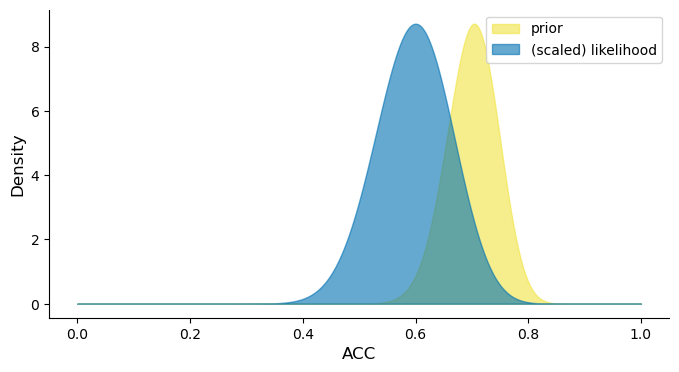

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom
import scipy.stats as st
from matplotlib.lines import Line2D  
import seaborn as sns

# 定义正确率的取值范围
acc_values = np.linspace(0, 1, 1000)

# 定义先验分布 Beta(70, 30)
alpha_prior = 70
beta_prior = 30
prior_distribution = beta(alpha_prior, beta_prior).pdf(acc_values)

# 定义似然分布 Bin(50, ACC)
n_trials = 50
y_observed = 30
likelihood = binom.pmf(y_observed, n_trials, acc_values)

# 绘图
fig, ax = plt.subplots(figsize=(8, 4))

ax.fill_between(acc_values, prior_distribution, color="#f0e442", alpha=0.6, label='prior')
likelihood_scaled = likelihood / np.max(likelihood) * np.max(prior_distribution)  # 缩放
ax.fill_between(acc_values, likelihood_scaled, color="#0071b2", alpha=0.6, label='(scaled) likelihood')

# 图例和标题
ax.set_xlabel('ACC', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(loc='upper right', fontsize=10)

# 创建自定义图例
custom_lines = [Line2D([], [], color="#f0e442"),
                Line2D([], [], color="#0071b2")]
        
# 移除图的上、右边框线
sns.despine()

**思考🧐**  

哪一张图正确反映了正确率ACC的后验模型？  

![Image Name](https://cdn.kesci.com/upload/skg2tifhs.png?imageView2/0/w/960/h/960)


我们可以画出后验分布图：

In [10]:
# 导入统计建模工具包 scipy.stats 为 st
import scipy.stats as st 

# 设置 x 轴范围 [0,1]
x = np.linspace(0,1,10000)
# 设置 Beta 分布参数
a,b = 70,30
# 形成先验分布 
prior = st.beta.pdf(x,a,b)/np.sum(st.beta.pdf(x,a,b))

# 形成似然
k = 30     # k 代表正确率为1的次数
n = 50     # n 代表总次数
likelihood = st.binom.pmf(k,n,x)

# 计算后验
unnorm_posterior = prior * likelihood                  # 计算分子
posterior = unnorm_posterior/np.sum(unnorm_posterior)  # 结合分母进行计算
likelihood = likelihood /np.sum(likelihood)            # 为了方便可视化，对似然进行类似后验的归一化操作 

# 绘图
plt.plot(x,posterior, color="#009e74", alpha=0.5, label="posterior")
plt.plot(x,likelihood, color="#0071b2", alpha=0.5, label="likelihood")
plt.plot(x,prior, color="#f0e442", alpha=0.5, label="prior")
plt.legend()
plt.xlabel("ACC")
plt.fill_between(x, prior, color="#f0e442", alpha=0.5)
plt.fill_between(x, likelihood, color="#0071b2", alpha=0.5)
plt.fill_between(x, posterior, color="#009e74", alpha=0.5)
sns.despine()

<Figure size 1000x400 with 1 Axes>

In [11]:
# ------

**正式计算**  

$$  
P(\text{ACC} | y = 30) = \frac{P(\text{ACC})L(\text{ACC}|y = 30)}{P(y = 30)}.  
$$  

和之前一样，分母$P(y = 30)$是一个常数，在计算中可以将其忽略  


$$  
P(\text{ACC} | y = 30) \propto \left[ \frac{\Gamma(100)}{\Gamma(70)\Gamma(30)} \cdot \binom{50}{30} \right] \cdot \text{ACC}^{69} (1 - \text{ACC})^{29} \cdot \text{ACC}^{30} (1 - \text{ACC})^{20}  
$$  

<center>[  ] 中的也是可以忽略的常数项<center>  




整理一下可知，后验分布可以表示为：  
$$  
P(\text{ACC} | y = 30) \propto \text{ACC}^{99} (1 - \text{ACC})^{49}  
$$  


根据这个公式，我们发现 $P(\pi | y=30)$ 和 $Beta(100,50)$ 有着相似的形状  

$$  
\text{Beta}(100, 50) = \frac{\Gamma(150)}{\Gamma(100)\Gamma(50)} \pi^{99} (1-\pi)^{49}  
$$  
实际上，在这里后验分布也确实是Beta分布：  

$$  
\pi | (Y = 30) \sim \text{Beta}(100,50)  
$$

**对后验模型进行总结**  

在结合先验和似然之后，我们对正确率ACC的认识发生了更新。  

需要注意的是：后验模型仍然是一个$Beta$分布，和先验模型是同一个分布族。  

$$  
ACC | (Y = 30) \sim \text{Beta}(100,50)  
$$  

$$  
f(\text{ACC} | y = 30) = \frac{\Gamma(200)}{\Gamma(100)\Gamma(100)} \text{ACC}^{99} (1-\text{ACC})^{99}  
$$  


所以我们也可以对二者进行对比，下表进行了这一总结，可以发现，在新的数据产生之后：  

例如：  

- 对正确率的期望值从0.70降低为0.67；  

- 模型的标准差从0.0657减少为0.0471；  
	
|    |prior  |posterior  
|----|-----|----|  
|$\alpha$   |70  |100 |  
|$\beta$   |30  |50 |  
|mean   |0.70  |0.67 |  
|mode  |0.694  |0.663 |  
|var   |0.00432  |0.00222 |  
|sd   |0.0657  |0.0471 |  

**思考🧐**  

- 先验分布的形态是否决定了后验分布的形态？(还记得之前关于正态分布和Beta分布的例子吗)  
- 先验分布和后验分布是否必然一致？

## Part 4: Beta-Binomial model and simulation

**Beta-Binomial model 的一般数学形式**  

在前一节中，我们对随机点运动任务的正确率ACC建立了基本、更加完整的Beta-Binomial模型。  

- 我们现在假设了一个特定的Beta(45,55)先验分布和特定的正确判断次数（正确次数： Y = 30，总试次： n = 50）。  
- 这只是Beta-Binomial模型的一个特例。 实际上 Beta 模型可以适用于任何参数范围在[0,1]的场景。  
- 例如，硬币为正面的倾向，可重复研究的比率或是疫苗的有效率。  

$$  
\begin{split}  
Y | ACC & \sim \text{Bin}(n, ACC) \\  
ACC & \sim \text{Beta}(\alpha, \beta). \\  
\end{split}  
$$  


无论是哪种情况，在观察到 n 次时间中有 $Y = y$次目标事件后，ACC的后验分布可以用Beta模型来描述，反映了先验（通过$\alpha$和$\beta$）和数据（通过$y$和$n$）的影响：  

$$  
\begin{equation}  
ACC | (Y = y) \sim \text{Beta}(\alpha + y, \beta + n - y)  .  
\end{equation}  
$$  


需要注意的是，后验与先验是相同的概率模型，只是参数不同  

- 在这个例子中，Beta($\alpha$, $\beta$)模型是对应数据模型的 $\text{Bin}(n, ACC)$ 的**共轭先验 (conjugate prior)**。  
- 如果 $f(ACC)$ 是 $L(ACC|y)$ 的共轭先验，后验 $f(ACC|y) \propto f(ACC)L(ACC|y)$ 与先验来自相同的模型族。  
- 我们将在第五次课详细介绍共轭先验的相关知识。  


**代码实现**  

让我们模拟正确率ACC的后验模型。  

- 首先，我们从Beta(45,55)先验中模拟10,000个ACC值  
- 然后, 使用从每个ACC值中模拟Bin(50,ACC)的潜在正确判断次数Y：  

模拟结果：10,000对ACC和y值的模拟数据  


In [12]:
# 导入数据加载和处理包：pandas
import pandas as pd
# 导入数字和向量处理包：numpy
import numpy as np
# 导入基本绘图工具：matplotlib
import matplotlib.pyplot as plt

# 设置随机种子，以便后续可以重复结果
np.random.seed(84735)

# 模拟 10000 次数据
king_sim = pd.DataFrame({'ACC': np.random.beta(45, 55, size=10000)})  # 从Beta(45,55)先验中模拟10,000个ACC值
king_sim['y'] = np.random.binomial(n=50, p=king_sim['ACC'])       # 从每个ACC值中模拟Bin(50,ACC)的潜在正确判断次数Y

# 显示部分数据
king_sim.head()

,ACC,y
0,0.479492,28
1,0.385205,16
2,0.412269,19
3,0.458158,20
4,0.397845,24


通过散点图观察以上数据的关系:  
- 黑色点表示正确次数$Y\neq30$的部分。  
- 蓝色点表示正确次数$Y=30$的部分。

In [13]:
# 绘制散点图：正确次数 (Y!=30)部分，用黑色表示
plt.scatter(king_sim['ACC'][king_sim['y']!=30], 
            king_sim['y'][king_sim['y']!=30], 
            c='black', s = 3,
            label='FALSE')
# 绘制散点图：正确次数 (Y=30)部分，用蓝色表示
plt.scatter(king_sim['ACC'][king_sim['y']==30],
            king_sim['y'][king_sim['y']==30],
            c='b', s = 20, 
            label='TRUE')

# 显示图片
plt.legend(title = "y==30")
plt.xlabel('ACC')
plt.ylabel('Y')
plt.show()

<Figure size 1000x400 with 1 Axes>

当我们仅关注与我们的Y = 30正确次数匹配的对时，剩下的ACC值的很好地逼近了后验模型Beta(75,75)：

In [14]:
# 导入绘图工具 seaborn 为 sns
import seaborn as sns

# 从模拟数据中筛选出 y 值为 30 的样本，生成对应的后验分布。
king_posterior = king_sim[king_sim['y'] == 30]

# 绘制分布图：概率密度+柱状图
sns.displot(king_posterior['ACC'], kde=True)
plt.xlabel('ACC')
plt.ylabel('Density')
plt.show()

<Figure size 500x500 with 1 Axes>

同时绘制出先验、似然和后验。

In [15]:
# 导入统计建模工具包 scipy.stats 为 st
import scipy.stats as st 

# 设置 x 轴范围 [0,1]
x = np.linspace(0,1,10000)
# 设置 Beta 分布参数
a,b = 45,55

# 形成先验分布 
prior = st.beta.pdf(x,a,b)/np.sum(st.beta.pdf(x,a,b))

# 形成似然
k = 30                  # k 代表正确率为1的次数
n = 50                  # n 代表总次数
likelihood = st.binom.pmf(k,n,x)

# 计算后验
unnorm_posterior = prior * likelihood                  # 计算分子
posterior = unnorm_posterior/np.sum(unnorm_posterior)  # 结合分母进行计算
likelihood = likelihood /np.sum(likelihood)            # 为了方便可视化，对似然进行类似后验的归一化操作 

# 绘图
plt.plot(x,posterior, color="#009e74", alpha=0.5, label="posterior")
plt.plot(x,likelihood, color="#0071b2", alpha=0.5, label="likelihood")
plt.plot(x,prior, color="#f0e442", alpha=0.5, label="prior")
plt.legend()
plt.xlabel("ACC")
plt.fill_between(x, prior, color="#f0e442", alpha=0.5)
plt.fill_between(x, likelihood, color="#0071b2", alpha=0.5)
plt.fill_between(x, posterior, color="#009e74", alpha=0.5)
plt.xlim([0,1])
plt.show()

<Figure size 1000x400 with 1 Axes>

In [16]:
# ------

我们还可以使用模拟样本近似后验特征，例如随机点运动任务正确率的均值和标准差。  

- 结果与上面计算的理论值非常相似，$E(ACC∣Y = 30) = 0.5024$ 和 $SD(ACC∣Y = 30) = 0.0394$：  
- 在解释这些模拟结果时，“近似”是一个关键词。由于我们10,000次模拟中只有219次与观测到的Y = 30数据匹配，通过将原始模拟次数从10,000增加到50,000，可以改善这个近似值：

In [17]:
print(
  "近似值：", 
  "均值，",
  king_posterior['ACC'].mean(), 
  "。标准差，",
  king_posterior['ACC'].std()
)

近似值： 均值， 0.5024772340319912 。标准差， 0.0394983348061003


In [18]:
print(f"10,000次模拟中, {king_posterior.shape[0]}次与观测到的Y = 30数据匹配")

# 模拟新的数据
size = 50000 # 不同于之前的 10000
king_sim2 = pd.DataFrame({'ACC': np.random.beta(45, 55, size=size)})
king_sim2['y'] = np.random.binomial(n=50, p=king_sim2['ACC'])
king_posterior2 = king_sim2[king_sim2['y'] == 30]
print(f"50,000次模拟中, {king_posterior2.shape[0]}次与观测到的Y = 30数据匹配")

10,000次模拟中, 219次与观测到的Y = 30数据匹配
50,000次模拟中, 1045次与观测到的Y = 30数据匹配


### <center> 🎈总结 </center>  

在第3章中，我们对一个真实的现象(随机点运动任务中特定条件下正确判断的能力)，构建了Beta-Binomial模型，并通过数据进行了一次信念更新：  

$$  
\begin{split}  
Y | ACC &\sim \text{Bin}(n, ACC) \\  
ACC &\sim \text{Beta}(\alpha, \beta)  
\end{split}  
\Rightarrow ACC | (Y = y) \sim \text{Beta}(\alpha + y, \beta + n - y).  
$$  


这个模型反映了贝叶斯分析的四个通用要素:  

1. 先验模型 Beta先验模型可以通过调节参数来反映不同的ACC值在[0,1]范围内的相对先验可能性。  

$$  
f(ACC) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}ACC^{\alpha - 1}(1-ACC)^{\beta - 1}.  
$$  

2. 数据模型 为了学习ACC,我们收集数据$Y$,即$n$次独立试验中成功的次数,其中每次试验正确的概率为ACC。$Y$对ACC的依赖关系由二项分布$Bin(n, ACC)$描述。  

3. 似然函数 在观测到数据$Y=y$,其中$y\in{0,1,...,n}$后,ACC的似然函数通过将$y$代入二项式概率质量函数而获得,它提供了一种机制来比较不同ACC与数据的兼容性:  

$$  
L(ACC|y) = \binom{n}{y}ACC^y(1-ACC)^{n-y} \text{ for } ACC \in [0,1].  
$$  

4. 后验模型 通过贝叶斯规则,共轭的Beta先验和二项式数据模型结合产生ACC的Beta后验模型。更新的Beta后验参数($\alpha$ + $y$, $\beta$ + $n$ - $y$)反映了先验的影响(通过$\alpha$和$\beta$)和观测数据的影响(通过$y$和$n$)。  

$$  
f(ACC|y) \propto f(ACC)L(ACC|y) \propto ACC^{(\alpha+y)-1}(1-ACC^{(\beta+n-y)-1}.  
$$  


**🥋练习**  

- 假设心理学研究中的可重复研究出现的概率为 0.4（这里概率用$\pi$表示）， 请自行选择一个合适的 Beta 分布，模拟10000个$\pi$值。  
- 请根据$\pi$模拟相应的数据 $Y$ (可重复研究的数量)，假设总的可重复研究数量 $n = 100$。  
- 绘制先验分布和后验分布的图像。

### 💐Bonus 1：Beta(70,30)这个先验是怎么选取的?

**Beta分布的集中趋势量数**  

在回答这个问题之前，我们先来了解一下**Beta分布的集中趋势量数**  

需要注意的是，虽然我们可能比较熟悉计算正态分布的均值、众数和标准差；但 Beta 分布的相关统计量的计算有所不同：  

![Image Name](https://cdn.kesci.com/upload/s0ywp66o5v.png?imageView2/0/w/500/h/500)  
>source:https://en.wikipedia.org/wiki/Probability_density_function  

**1. 平均数(mean)**  

- ACC的平均取值  
$$  
E(ACC)  = \frac{\alpha}{\alpha + \beta}  
$$  
$$  
E(ACC) = \int ACC \cdot f(ACC)dACC.  
$$  

**2. 众数(mode)**  

- ACC最可能的取值。即，在ACC下，$f(ACC)$能取到最大值。  

$$  
\text{Mode}(ACC)  = \frac{\alpha - 1}{\alpha + \beta - 2} \;\;\; \text{ when } \; \alpha, \beta > 1.  
$$  
$$  
\text{Mode}(ACC) = \text{argmax}_{ACC}f(ACC).  
$$  
**3. 方差(variance)**  

- $ACC$取值的变异性(variability)  
$$  
\text{Var}(ACC) = E((ACC - E(ACC))^2) = \int (ACC - E(ACC))^2 \cdot f(ACC) dACC.  
$$  

$$  
\text{Var}(ACC) = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)} .  
$$  

**4. 标准差(standard deviation)**  
$$  
\text{SD}(ACC) = \sqrt{\text{Var}(ACC)} .  
$$  

-------  
-------------

**调整Beta先验**  

我们已经知道，在先前的推测中，在 5% 一致性条件下，被试的平均正确率约为 70%。根据这一点，我们可以计算出 Beta 分布的$\alpha$和 $\beta$参数。  
$$  
E(ACC) = \frac{\alpha}{\alpha + \beta} = 0.70  
$$  
重新整理过后：  
$$  
\alpha = 0.70(\alpha + \beta)  
$$  

$$  
\alpha \approx \frac{7}{3} \beta  
$$  

一个合适的分布中，$\alpha$和$\beta$需要满足的条件如上，我们可以选择 *Beta(70,30), Beta(7,3), Beta(14,6)*，我们可以通过以下代码来画出这些分布的形状

In [19]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13, 5))
pz.Beta(70, 30).plot_pdf(pointinterval=True,ax=ax)
pz.Beta(7, 3).plot_pdf(pointinterval=True,ax=ax)
pz.Beta(14, 6).plot_pdf(pointinterval=True,ax=ax)
plt.tight_layout()
plt.show()

<Figure size 1300x500 with 1 Axes>

如图所示，我们选择$ACC \sim \text{Beta}(70,30)$作为先验模型  

带入公式，可以计算出$先验f(ACC)$的pdf、平均数、众数、方差和标准差：  

- pdf:  
$$  
f(ACC) = \frac{\Gamma(100)}{\Gamma(70)\Gamma(30)}ACC^{69}(1-ACC)^{29} \;\; \text{ for } ACC \in [0,1].  
$$  

- 平均数:  
$$  
E(ACC) = \frac{70}{70 + 30} = 0.70  
$$  

- 众数:  
$$  
\text{Mode}(ACC) = \frac{70 - 1}{70 + 30 - 2} = 0.6939  
$$  

- 方差:  
$$  
\text{Var}(ACC) = \frac{70 \cdot 30}{(70 + 30)^2(70 + 30 + 1)} = 0.0021  
$$  

- 标准差：  
$$  
\text{SD}(ACC) = \sqrt{0.0021} = 0.0458  
$$

### 💐Bonus2 Beta-Binomial 模型生成的后验仍是Beta分布

**公式推导**  

对于 $ACC$ 的后验模型为 $Beta(α + y, β + n − y)$ 的推导过程 (其中，正确次数为y，总试次为n)。  

1. 首先写出先验的公式  

$$  
\begin{equation}  
f(ACC) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}ACC^{\alpha - 1}(1-ACC)^{\beta - 1}  
\;\; \text{ and } \;\;  
L(ACC|y) = \left(\!\!\begin{array}{c} n \\ y\end{array}\!\!\right) ACC^{y} (1-ACC)^{n-y}  .  
\end{equation}  
$$  

2. 结合先验和似然函数 (暂时忽略分母)，后验概率密度函数可以由贝叶斯定理得到：  

$$  
\begin{split}  
f(ACC | y)  
& \propto f(ACC)L(ACC|y) \\  
& = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}ACC^{\alpha - 1}(1-ACC)^{\beta - 1}  \cdot \left(\!\begin{array}{c} n \\ y \end{array}\!\right) ACC^{y} (1-ACC)^{n-y} \\  
& \propto ACC^{(\alpha + y) - 1} (1-ACC)^{(\beta + n - y) - 1}  .\\  
\end{split}  
$$  



3. 最后，我们加上归一化因子(分母部分)：  

$$  
f(ACC|y) = \frac{\Gamma(\alpha+\beta+n)}{\Gamma(\alpha+y)\Gamma(\beta+n-y)}ACC^{(\alpha + y) - 1} (1-ACC)^{(\beta + n - y) - 1}.  
$$  

我们知道$Beta(a,b)$的概率密度函数可以写为：  
$$  
Beta(α, β) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} ACC^{\alpha-1} (1-ACC)^{\beta-1} \;\;  for\; ACC \in [0,1] \  
$$  

因此，  

$$  
f(ACC|y) = Beta(α + y, β + n − y)  
$$